# 🔭 Assignment: Measuring Cosmological Parameters Using Type Ia Supernovae

In this assignment, you'll analyze observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to measure the Hubble constant $H_0$ and estimate the age of the universe. You will:

- Plot the Hubble diagram (distance modulus vs. redshift)
- Fit a cosmological model to derive $H_0$ and $\Omega_m$
- Estimate the age of the universe
- Analyze residuals to assess the model
- Explore the effect of fixing $\Omega_m$
- Compare low-z and high-z results

Let's get started!


## 📦 Getting Started: Setup and Libraries

Before we dive into the analysis, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions

Make sure these libraries are installed in your environment. If not, you can install them using:

```bash
pip install numpy pandas matplotlib scipy astropy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## 📂 Load the Pantheon+SH0ES Dataset

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


More detailed column names and the meanings can be referred here:

![image.png](attachment:image.png)

In [ ]:
# Local file path
file_path = "Pantheon+SH0ES.dat"

# Load the file
data = pd.read_csv(file_path, delim_whitespace=True, comment='#')

# See structure


/tmp/ipython-input-2-2084571041.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, comment='#')


## 🧾 Preview Dataset Columns

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


In [ ]:
z = data['zHD'].values
mu = data['MU_SH0ES'].values
mu_err = data['MU_SH0ES_ERR_DIAG'].values

## 🧹 Clean and Extract Relevant Data

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [ ]:
# Filter for entries with usable data based on the required columns

## 📈 Plot the Hubble Diagram

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


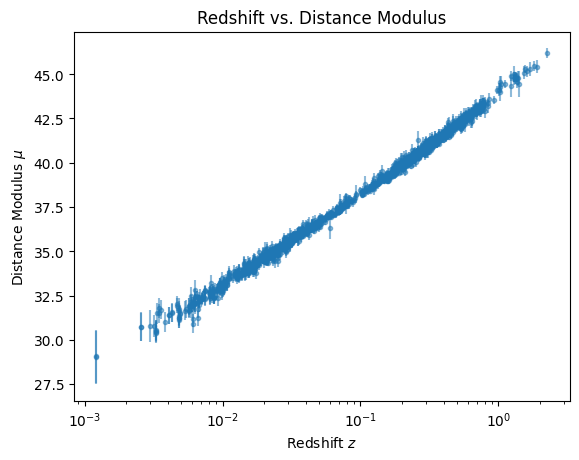

In [ ]:
# Write a code to plot the distance modulus and the redshift (x-axis), label them accordingly.

#Try using log scale in x-axis
plt.errorbar(z, mu, yerr=mu_err, fmt='.', alpha=0.5)
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\mu$')
plt.title('Redshift vs. Distance Modulus')
plt.xscale('log')  # Log scale for x-axis as suggested
plt.show()

## 🧮 Define the Cosmological Model

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model (read about the model in wikipedia if needed). This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [ ]:
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u
# Define the E(z) for flat LCDM
def E(z, Omega_m):
  return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance in Mpc, try using scipy quad to integrate.
def luminosity_distance(z, H0, Omega_m):
    integral, _ = quad(lambda zp: 1.0 / E(zp, Omega_m), 0, z)
    d_l = (c.to(u.km/u.s).value / H0) * (1 + z) * integral  # in Mpc
    return d_l

# Theoretical distance modulus, use above function inside mu_theory to compute luminosity distance
def mu_theory(z, H0, Omega_m):
    # Vectorize for array input
    d_l_vec = np.vectorize(lambda z_: luminosity_distance(z_, H0, Omega_m))
    d_l = d_l_vec(z)
    return 5 * np.log10(d_l * 1e6 / 10)  # Convert Mpc to pc

## 🔧 Fit the Model to Supernova Data

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


Fitted H0 = 72.97 ± 0.17 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.012


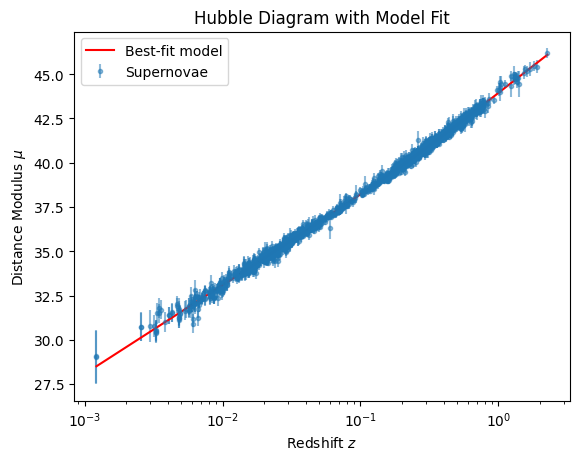

In [ ]:
from scipy.optimize import curve_fit
# Initial guess: H0 = 70, Omega_m = 0.3
p0 = [70, 0.3]

# Fitting function for curve_fit
def fit_func(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

# Fit and extract errors
popt, pcov = curve_fit(fit_func, z, mu, sigma=mu_err, p0=p0, bounds=([50, 0.1], [90, 0.5]))
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

# Plot the fit
z_plot = np.linspace(z.min(), z.max(), 200)
plt.errorbar(z, mu, yerr=mu_err, fmt='.', alpha=0.5, label='Supernovae')
plt.plot(z_plot, fit_func(z_plot, H0_fit, Omega_m_fit), 'r-', label='Best-fit model')
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\mu$')
plt.title('Hubble Diagram with Model Fit')
plt.legend()
plt.xscale('log')
plt.show()

## ⏳ Estimate the Age of the Universe

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [ ]:
# Function for age of the universe
def age_of_universe(H0, Omega_m):
    integral, _ = quad(lambda z: 1.0 / ((1 + z) * E(z, Omega_m)), 0, np.inf)
    # H0 in km/s/Mpc, convert to s^-1: 1 Mpc = 3.085677581491367e19 km
    H0_SI = H0 / (3.085677581491367e19)  # s^-1
    t0 = integral / H0_SI  # in seconds
    t0_gyr = t0 / (60 * 60 * 24 * 365.25 * 1e9)  # Convert to Gyr
    return t0_gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr


## 📊 Analyze Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


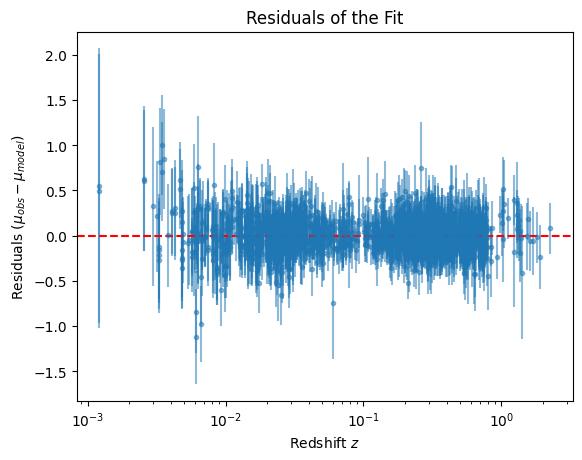

In [ ]:
# Compute model values
mu_model = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model

# Plot the residuals
plt.errorbar(z, residuals, yerr=mu_err, fmt='.', alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Redshift $z$')
plt.ylabel('Residuals ($\mu_{obs} - \mu_{model}$)')
plt.title('Residuals of the Fit')
plt.xscale('log')
plt.show()

## 🔧 Fit with Fixed Matter Density

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [ ]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Try fitting with this fixed value
popt_fixed, pcov_fixed = curve_fit(mu_fixed_Om, z, mu, sigma=mu_err, p0=[70])
H0_fixed = popt_fixed[0]
H0_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]
print(f"Fitted H0 (Omega_m=0.3): {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

Fitted H0 (Omega_m=0.3): 73.53 ± 0.11 km/s/Mpc


## 🔍 Compare Low-z and High-z Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [ ]:
# Split the data for the three columns and do the fitting again and see
z_split = 0.1
low_mask = z < z_split
high_mask = z >= z_split

# Fit for low-z
popt_low, _ = curve_fit(mu_fixed_Om, z[low_mask], mu[low_mask], sigma=mu_err[low_mask], p0=[70])
H0_low = popt_low[0]
# Fit for high-z
popt_high, _ = curve_fit(mu_fixed_Om, z[high_mask], mu[high_mask], sigma=mu_err[high_mask], p0=[70])
H0_high = popt_high[0]

print(f"Low-z (z < {z_split}): H₀ = {H0_low:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high:.2f} km/s/Mpc")

Low-z (z < 0.1): H₀ = 73.01 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 km/s/Mpc


You can check your results and potential reasons for different values from accepted constant using this paper by authors of the [Pantheon+ dataset](https://arxiv.org/pdf/2310.11727)

You can find more about the dataset in the paper too